In [1]:
import requests
import pandas as pd
import hvplot.pandas
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import locale
import time

load_dotenv()

True

In [2]:
api_key = os.getenv('CENSUS_API_KEY')

In [3]:
# Declare variables used to construct an API request
base_uri = 'https://api.census.gov/data/timeseries/intltrade/imports/porths'
fields = 'PORT,PORT_NAME,GEN_VAL_YR,YEAR'

# Declare a list that will be used to store dfs for each year
list_of_port_dfs = []

In [4]:
# Iterate through range of years and request US import port data for each year
for yr in range(2012, 2023):
    
    try:
        r = requests.get(f'{base_uri}?get={fields}&time={yr}-12&key={api_key}')
        data = r.json()
        df = pd.DataFrame(data)
        list_of_port_dfs.append(df)
        
    except: continue
    

us_import_port_df = pd.concat(list_of_port_dfs)
us_import_port_df.head()

,0,1,2,3,4
0,PORT,PORT_NAME,GEN_VAL_YR,YEAR,time
1,-,TOTAL FOR ALL PORTS,2276267147199,2012,2012-12
2,0101,"PORTLAND, ME",2605248644,2012,2012-12
3,0102,"BANGOR, ME",2394534076,2012,2012-12
4,0103,"EASTPORT, ME",4922822,2012,2012-12


In [5]:
# Use first row to set columns
us_import_port_df.columns = us_import_port_df.iloc[0]

# Slice out headers and summary rows and reset index
us_import_port_df = us_import_port_df[2:].reset_index(drop=True)

display(us_import_port_df.head())
display(us_import_port_df.tail())

,PORT,PORT_NAME,GEN_VAL_YR,YEAR,time
0,0101,"PORTLAND, ME",2605248644,2012,2012-12
1,0102,"BANGOR, ME",2394534076,2012,2012-12
2,0103,"EASTPORT, ME",4922822,2012,2012-12
3,0104,"JACKMAN, ME",387677439,2012,2012-12
4,0105,"VANCEBORO, ME",257695889,2012,2012-12


,PORT,PORT_NAME,GEN_VAL_YR,YEAR,time
4149,5583,"FORT WORTH ALLIANCE AIRPORT, TX",1064365,2022,2022-12
4150,5584,"ADDISON AIRPORT, DALLAS, TX",474587,2022,2022-12
4151,5588,"DALLAS LOVE FIELD, DALLAS, TX",893856,2022,2022-12
4152,6000,VESSELS UNDER OWN POWER,9080867,2022,2022-12
4153,7070,LOW VALUE,21669585007,2022,2022-12


In [6]:
# Remove totals
us_import_totals_df = us_import_port_df[us_import_port_df['PORT'] == '-']
us_import_port_df = us_import_port_df[us_import_port_df['PORT'] != '-']

In [7]:
# Cast GEN_VAL_YR (i.e. Year-to-date total value of general goods) to float
us_import_port_df['GEN_VAL_YR'] = pd.to_numeric(us_import_port_df['GEN_VAL_YR'], errors='coerce')
us_import_port_df['GEN_VAL_YR'] = us_import_port_df['GEN_VAL_YR'].astype(float)

In [8]:
# Create series datetime
us_import_port_df['datetime'] = pd.to_datetime(us_import_port_df['time'], format='%Y-%m', errors='coerce')
us_import_port_df.head()

,PORT,PORT_NAME,GEN_VAL_YR,YEAR,time,datetime
0,0101,"PORTLAND, ME",2.605249e+09,2012,2012-12,2012-12-01
1,0102,"BANGOR, ME",2.394534e+09,2012,2012-12,2012-12-01
2,0103,"EASTPORT, ME",4.922822e+06,2012,2012-12,2012-12-01
3,0104,"JACKMAN, ME",3.876774e+08,2012,2012-12,2012-12-01
4,0105,"VANCEBORO, ME",2.576959e+08,2012,2012-12,2012-12-01


In [9]:
# Grouping by Port to calculate the total summed value for each port
port_totals = us_import_port_df\
    .groupby(['PORT', 'PORT_NAME'])['GEN_VAL_YR']\
    .sum()\
    .reset_index()

# Sorting the ports based on their total summed values in descending order
sorted_ports = port_totals.sort_values('GEN_VAL_YR', ascending=False)

In [10]:
# Selecting the top 10 ports with the highest summed values
top_10_ports = sorted_ports.head(10)
top_10_ports

,PORT,PORT_NAME,GEN_VAL_YR
182,2704,"LOS ANGELES, CA",2.757943e+12
62,1003,"NEWARK, NJ",1.883582e+12
352,3901,"CHICAGO, IL",1.770119e+12
153,2304,"LAREDO, TX",1.366580e+12
64,1012,"JFK INTERNATIONAL AIRPORT, NY",1.186959e+12
406,5301,"HOUSTON, TX",7.740045e+11
332,3801,"DETROIT, MI",7.662375e+11
102,1703,"SAVANNAH, GA",7.634869e+11
184,2709,"LONG BEACH, CA",7.504660e+11
128,2002,"NEW ORLEANS, LA",6.889729e+11


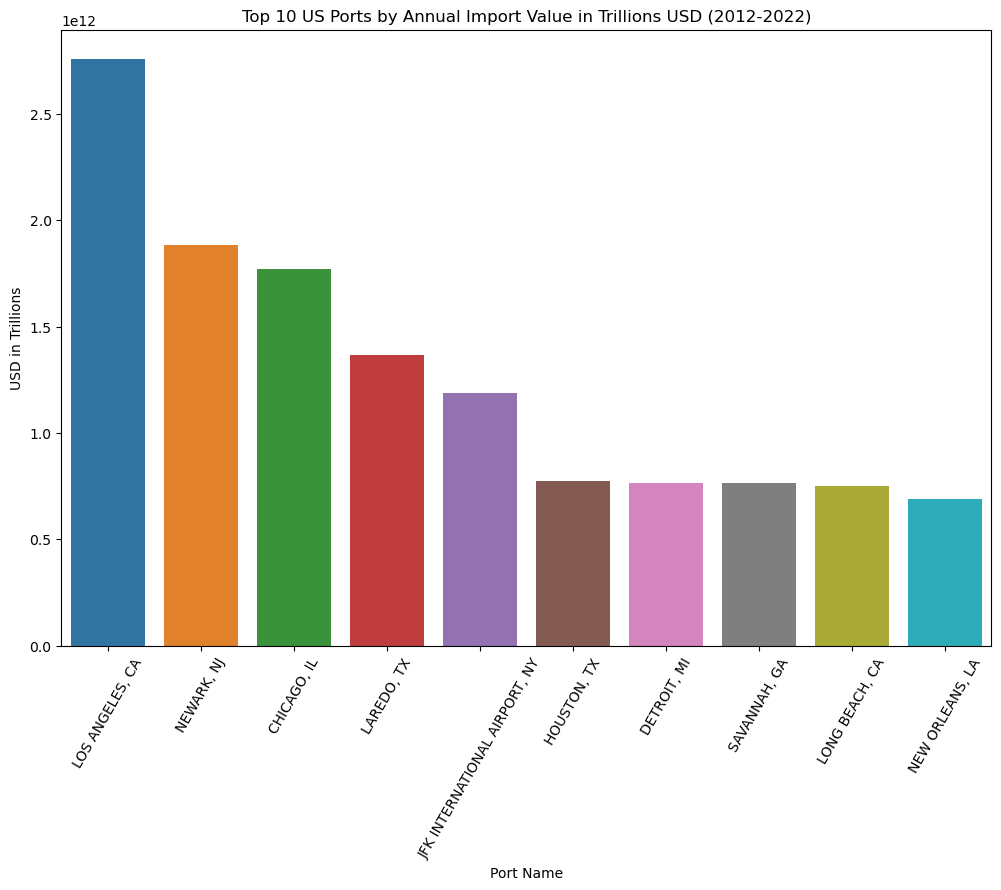

In [11]:
# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_10_ports, 
    x='PORT_NAME', 
    y='GEN_VAL_YR'
)
plt.xlabel('Port Name')
plt.ylabel('USD in Trillions')
plt.title('Top 10 US Ports by Annual Import Value in Trillions USD (2012-2022)')
plt.xticks(rotation=60)
plt.show()

![Top Us Ports](./plots/top_us_ports2.png)

In [12]:
# Plot the top ports
top_10_ports_plot = top_10_ports.hvplot(
    title='Top US Ports by Total Import Value 2012-2022',
    yformatter="$%.0f",
    kind='bar',
    x='PORT_NAME', 
    xlabel='Port Name',
    y='GEN_VAL_YR',
    ylabel='Total Value USD',
    hover_color='yellow',
    width=700,
    height=700,
    rot=20
)
top_10_ports_plot

:Bars   [PORT_NAME]   (GEN_VAL_YR)

![Top Us Ports](./plots/top_us_ports.png)

In [13]:
# Selecting the top 3 ports with the highest summed values
top_3_ports = sorted_ports.head(3)
top_3_ports

,PORT,PORT_NAME,GEN_VAL_YR
182,2704,"LOS ANGELES, CA",2.757943e+12
62,1003,"NEWARK, NJ",1.883582e+12
352,3901,"CHICAGO, IL",1.770119e+12


In [14]:
# For the top 3 US ports, fetch commodity & country data

port_dict = {}

def fetch_port_data(port_id, fields):
    
    # Create empty list to store dfs for port
    list_of_dfs = []
    
    for yr in range(2012, 2023):
        try:
            uri = f'{base_uri}?get=GEN_VAL_YR,PORT_NAME,{fields}&PORT={port_id}&time={yr}-12&key={api_key}';
            r = requests.get(uri)
            data = r.json()
            df = pd.DataFrame(data)
            list_of_dfs.append(df)
        except Exception as e:
            print(f"Error fetching data for {port_id} and year {yr}: {e}")
            continue
        
    return list_of_dfs

        
for i in range(3):
    
    # Declare var and assign row
    port = top_3_ports.iloc[i]
    
    # Add port as key to list
    if port.PORT not in port_dict:
        port_dict[port.PORT] = {
            'commodity_dfs': None,
            'country_dfs': None
        }
     
    commodity_dfs = fetch_port_data(port.PORT, 'I_COMMODITY,I_COMMODITY_LDESC')
    country_dfs = fetch_port_data(port.PORT, 'CTY_NAME,CTY_CODE')
    
    port_dict[port.PORT]['commodity_dfs'] = pd.concat(commodity_dfs)
    port_dict[port.PORT]['country_dfs'] = pd.concat(country_dfs)
    

In [15]:
# Iterate data structure
def iterate_data(d):
    for key, value in d.items():
        if isinstance(value, dict):
            iterate_data(value)
        elif hasattr(value, 'head'):
            print(value.head()) 

iterate_data(port_dict)

            0                1            2  \
0  GEN_VAL_YR        PORT_NAME  I_COMMODITY   
1    25026617  LOS ANGELES, CA         0203   
2       87371  LOS ANGELES, CA       020322   
3    24939246  LOS ANGELES, CA       020329   
4   159361057  LOS ANGELES, CA         0204   

                                                   3     4        5  
0                                  I_COMMODITY_LDESC  PORT     time  
1     MEAT OF SWINE (PORK), FRESH, CHILLED OR FROZEN  2704  2012-12  
2  MEAT OF SWINE, HAMS, SHOULDERS AND CUTS THEREO...  2704  2012-12  
3                       MEAT OF SWINE, NESOI, FROZEN  2704  2012-12  
4   MEAT OF SHEEP OR GOATS, FRESH, CHILLED OR FROZEN  2704  2012-12  
              0                1                      2         3     4  \
0    GEN_VAL_YR        PORT_NAME               CTY_NAME  CTY_CODE  PORT   
1    3348141572  LOS ANGELES, CA                   OPEC      0001  2704   
2    7626630305  LOS ANGELES, CA         EUROPEAN UNION      0003  2704 

In [16]:
# Create a df with the top US Port using countries
top_port_countries = port_dict[top_3_ports.iloc[0].PORT]['country_dfs']


# Create a df with the top US Port using commodities
top_port_commodities = port_dict[top_3_ports.iloc[0].PORT]['commodity_dfs']


# Display head of both
display(top_port_countries.head())

display(top_port_commodities.head())


,0,1,2,3,4,5
0,GEN_VAL_YR,PORT_NAME,CTY_NAME,CTY_CODE,PORT,time
1,3348141572,"LOS ANGELES, CA",OPEC,0001,2704,2012-12
2,7626630305,"LOS ANGELES, CA",EUROPEAN UNION,0003,2704,2012-12
3,200994607366,"LOS ANGELES, CA",PACIFIC RIM COUNTRIES,0014,2704,2012-12
4,1163354229,"LOS ANGELES, CA",CAFTA-DR,0017,2704,2012-12


,0,1,2,3,4,5
0,GEN_VAL_YR,PORT_NAME,I_COMMODITY,I_COMMODITY_LDESC,PORT,time
1,25026617,"LOS ANGELES, CA",0203,"MEAT OF SWINE (PORK), FRESH, CHILLED OR FROZEN",2704,2012-12
2,87371,"LOS ANGELES, CA",020322,"MEAT OF SWINE, HAMS, SHOULDERS AND CUTS THEREO...",2704,2012-12
3,24939246,"LOS ANGELES, CA",020329,"MEAT OF SWINE, NESOI, FROZEN",2704,2012-12
4,159361057,"LOS ANGELES, CA",0204,"MEAT OF SHEEP OR GOATS, FRESH, CHILLED OR FROZEN",2704,2012-12


In [17]:
# Assign header rows to columns attributes
top_port_countries.columns = top_port_countries.iloc[0]
top_port_commodities.columns = top_port_commodities.iloc[0]

display(top_port_countries.head())
display(top_port_commodities.head())


,GEN_VAL_YR,PORT_NAME,CTY_NAME,CTY_CODE,PORT,time
0,GEN_VAL_YR,PORT_NAME,CTY_NAME,CTY_CODE,PORT,time
1,3348141572,"LOS ANGELES, CA",OPEC,0001,2704,2012-12
2,7626630305,"LOS ANGELES, CA",EUROPEAN UNION,0003,2704,2012-12
3,200994607366,"LOS ANGELES, CA",PACIFIC RIM COUNTRIES,0014,2704,2012-12
4,1163354229,"LOS ANGELES, CA",CAFTA-DR,0017,2704,2012-12


,GEN_VAL_YR,PORT_NAME,I_COMMODITY,I_COMMODITY_LDESC,PORT,time
0,GEN_VAL_YR,PORT_NAME,I_COMMODITY,I_COMMODITY_LDESC,PORT,time
1,25026617,"LOS ANGELES, CA",0203,"MEAT OF SWINE (PORK), FRESH, CHILLED OR FROZEN",2704,2012-12
2,87371,"LOS ANGELES, CA",020322,"MEAT OF SWINE, HAMS, SHOULDERS AND CUTS THEREO...",2704,2012-12
3,24939246,"LOS ANGELES, CA",020329,"MEAT OF SWINE, NESOI, FROZEN",2704,2012-12
4,159361057,"LOS ANGELES, CA",0204,"MEAT OF SHEEP OR GOATS, FRESH, CHILLED OR FROZEN",2704,2012-12


In [18]:
# Reset index and drop header row
top_port_countries = top_port_countries[1:].reset_index(drop=True)
top_port_commodities = top_port_commodities[1:].reset_index(drop=True)

display(top_port_countries.head())
display(top_port_commodities.head())

,GEN_VAL_YR,PORT_NAME,CTY_NAME,CTY_CODE,PORT,time
0,3348141572,"LOS ANGELES, CA",OPEC,0001,2704,2012-12
1,7626630305,"LOS ANGELES, CA",EUROPEAN UNION,0003,2704,2012-12
2,200994607366,"LOS ANGELES, CA",PACIFIC RIM COUNTRIES,0014,2704,2012-12
3,1163354229,"LOS ANGELES, CA",CAFTA-DR,0017,2704,2012-12
4,1961022962,"LOS ANGELES, CA",NAFTA,0020,2704,2012-12


,GEN_VAL_YR,PORT_NAME,I_COMMODITY,I_COMMODITY_LDESC,PORT,time
0,25026617,"LOS ANGELES, CA",0203,"MEAT OF SWINE (PORK), FRESH, CHILLED OR FROZEN",2704,2012-12
1,87371,"LOS ANGELES, CA",020322,"MEAT OF SWINE, HAMS, SHOULDERS AND CUTS THEREO...",2704,2012-12
2,24939246,"LOS ANGELES, CA",020329,"MEAT OF SWINE, NESOI, FROZEN",2704,2012-12
3,159361057,"LOS ANGELES, CA",0204,"MEAT OF SHEEP OR GOATS, FRESH, CHILLED OR FROZEN",2704,2012-12
4,66016777,"LOS ANGELES, CA",020422,"MEAT OF SHEEP, CUTS WITH BONE IN, NESOI, FRESH...",2704,2012-12


In [19]:
# Cast GEN_VAL_YR (i.e. Year-to-date total value of general goods) to float
top_port_countries['GEN_VAL_YR'] = pd.to_numeric(top_port_countries['GEN_VAL_YR'], errors='coerce')
top_port_countries['GEN_VAL_YR'] = top_port_countries['GEN_VAL_YR'].astype(float)

top_port_commodities['GEN_VAL_YR'] = pd.to_numeric(top_port_commodities['GEN_VAL_YR'], errors='coerce')
top_port_commodities['GEN_VAL_YR'] = top_port_commodities['GEN_VAL_YR'].astype(float)

In [20]:
# Create series datetime
top_port_countries['datetime'] = pd.to_datetime(top_port_countries['time'], format='%Y-%m', errors='coerce')

top_port_commodities['datetime'] = pd.to_datetime(top_port_commodities['time'], format='%Y-%m', errors='coerce')

display(top_port_countries.head())
display(top_port_commodities.head())


,GEN_VAL_YR,PORT_NAME,CTY_NAME,CTY_CODE,PORT,time,datetime
0,3.348142e+09,"LOS ANGELES, CA",OPEC,0001,2704,2012-12,2012-12-01
1,7.626630e+09,"LOS ANGELES, CA",EUROPEAN UNION,0003,2704,2012-12,2012-12-01
2,2.009946e+11,"LOS ANGELES, CA",PACIFIC RIM COUNTRIES,0014,2704,2012-12,2012-12-01
3,1.163354e+09,"LOS ANGELES, CA",CAFTA-DR,0017,2704,2012-12,2012-12-01
4,1.961023e+09,"LOS ANGELES, CA",NAFTA,0020,2704,2012-12,2012-12-01


,GEN_VAL_YR,PORT_NAME,I_COMMODITY,I_COMMODITY_LDESC,PORT,time,datetime
0,25026617.0,"LOS ANGELES, CA",0203,"MEAT OF SWINE (PORK), FRESH, CHILLED OR FROZEN",2704,2012-12,2012-12-01
1,87371.0,"LOS ANGELES, CA",020322,"MEAT OF SWINE, HAMS, SHOULDERS AND CUTS THEREO...",2704,2012-12,2012-12-01
2,24939246.0,"LOS ANGELES, CA",020329,"MEAT OF SWINE, NESOI, FROZEN",2704,2012-12,2012-12-01
3,159361057.0,"LOS ANGELES, CA",0204,"MEAT OF SHEEP OR GOATS, FRESH, CHILLED OR FROZEN",2704,2012-12,2012-12-01
4,66016777.0,"LOS ANGELES, CA",020422,"MEAT OF SHEEP, CUTS WITH BONE IN, NESOI, FRESH...",2704,2012-12,2012-12-01


In [21]:
# Grouping by Port to calculate the total summed value for each port
country_totals = top_port_countries\
    .groupby(['CTY_CODE', 'CTY_NAME'])['GEN_VAL_YR']\
    .sum()\
    .reset_index()

commodity_totals = top_port_commodities\
    .groupby(['I_COMMODITY', 'I_COMMODITY_LDESC'])['GEN_VAL_YR']\
    .sum()\
    .reset_index()

# Sorting the ports based on their total summed values in descending order
sorted_countries = country_totals.sort_values('GEN_VAL_YR', ascending=False)[1:]
sorted_commodities = commodity_totals.sort_values('GEN_VAL_YR', ascending=False)[1:]

display(sorted_countries.head())
display(sorted_commodities.head())


,CTY_CODE,CTY_NAME,GEN_VAL_YR
163,5XXX,ASIA,2.548433e+12
11,0026,APEC,2.503245e+12
3,0014,PACIFIC RIM COUNTRIES,2.190527e+12
157,5700,CHINA,1.387064e+12
7,0022,OECD,6.182910e+11


,I_COMMODITY,I_COMMODITY_LDESC,GEN_VAL_YR
5604,85,ELECTRICAL MACHINERY AND EQUIPMENT AND PARTS T...,4.756443e+11
4962,84,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",4.576539e+11
5984,87,"VEHICLES, OTHER THAN RAILWAY OR TRAMWAY ROLLIN...",2.444033e+11
3571,61,"ARTICLES OF APPAREL AND CLOTHING ACCESSORIES, ...",1.584477e+11
6439,94,"FURNITURE;BEDDING,MATTRESSES,SUPPORTS,CUSHIONS...",1.396300e+11


In [22]:
# Get top 10 countries for top US Port
top_10_countries = sorted_countries.head(10)
top_10_commodities = sorted_commodities.head(10)


display(top_10_countries)
display(top_10_commodities)

,CTY_CODE,CTY_NAME,GEN_VAL_YR
163,5XXX,ASIA,2.548433e+12
11,0026,APEC,2.503245e+12
3,0014,PACIFIC RIM COUNTRIES,2.190527e+12
157,5700,CHINA,1.387064e+12
7,0022,OECD,6.182910e+11
12,0027,ASEAN,4.657519e+11
162,5880,JAPAN,3.549368e+11
145,5520,VIETNAM,1.895202e+11
161,5830,TAIWAN,1.363101e+11
159,5800,"KOREA, SOUTH",1.268870e+11


,I_COMMODITY,I_COMMODITY_LDESC,GEN_VAL_YR
5604,85,ELECTRICAL MACHINERY AND EQUIPMENT AND PARTS T...,4.756443e+11
4962,84,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",4.576539e+11
5984,87,"VEHICLES, OTHER THAN RAILWAY OR TRAMWAY ROLLIN...",2.444033e+11
3571,61,"ARTICLES OF APPAREL AND CLOTHING ACCESSORIES, ...",1.584477e+11
6439,94,"FURNITURE;BEDDING,MATTRESSES,SUPPORTS,CUSHIONS...",1.396300e+11
3895,64,"FOOTWEAR, GAITERS AND THE LIKE; PARTS OF SUCH ...",1.323624e+11
6000,8703,MOTOR CARS AND OTHER MOTOR VEHICLES DESIGNED T...,1.172023e+11
3695,62,"ARTICLES OF APPAREL AND CLOTHING ACCESSORIES, ...",1.131576e+11
6512,95,"TOYS, GAMES AND SPORTS EQUIPMENT; PARTS AND AC...",1.126714e+11
5486,8471,AUTOMATIC DATA PROCESSING MACHINES AND UNITS T...,9.601498e+10


In [23]:
# What are the top 10 commodities?

for i in range(len(top_10_commodities)):
    print(f'Commodity Description: \n\n{top_10_commodities.iloc[i].I_COMMODITY_LDESC}\n')
    print(f'Import Value: ${top_10_commodities.iloc[i].GEN_VAL_YR}')
    print('\n\n------------------------------------------------\n\n')


Commodity Description: 

ELECTRICAL MACHINERY AND EQUIPMENT AND PARTS THEREOF; SOUND RECORDERS AND REPRODUCERS, TELEVISION RECORDERS AND REPRODUCERS, PARTS AND ACCESSORIES

Import Value: $475644309533.0


------------------------------------------------


Commodity Description: 

NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHANICAL APPLIANCES; PARTS THEREOF

Import Value: $457653907576.0


------------------------------------------------


Commodity Description: 

VEHICLES, OTHER THAN RAILWAY OR TRAMWAY ROLLING STOCK, AND PARTS AND ACCESSORIES THEREOF

Import Value: $244403319106.0


------------------------------------------------


Commodity Description: 

ARTICLES OF APPAREL AND CLOTHING ACCESSORIES, KNITTED OR CROCHETED

Import Value: $158447672549.0


------------------------------------------------


Commodity Description: 

FURNITURE;BEDDING,MATTRESSES,SUPPORTS,CUSHIONS,STUFFED FURNISH;LUMINAIRES,LIGHTING FITTINGS,NESOI;ILLUMINATED SIGNS,NAME-PLATES ETC;PREFAB BUILDINGS

Import V

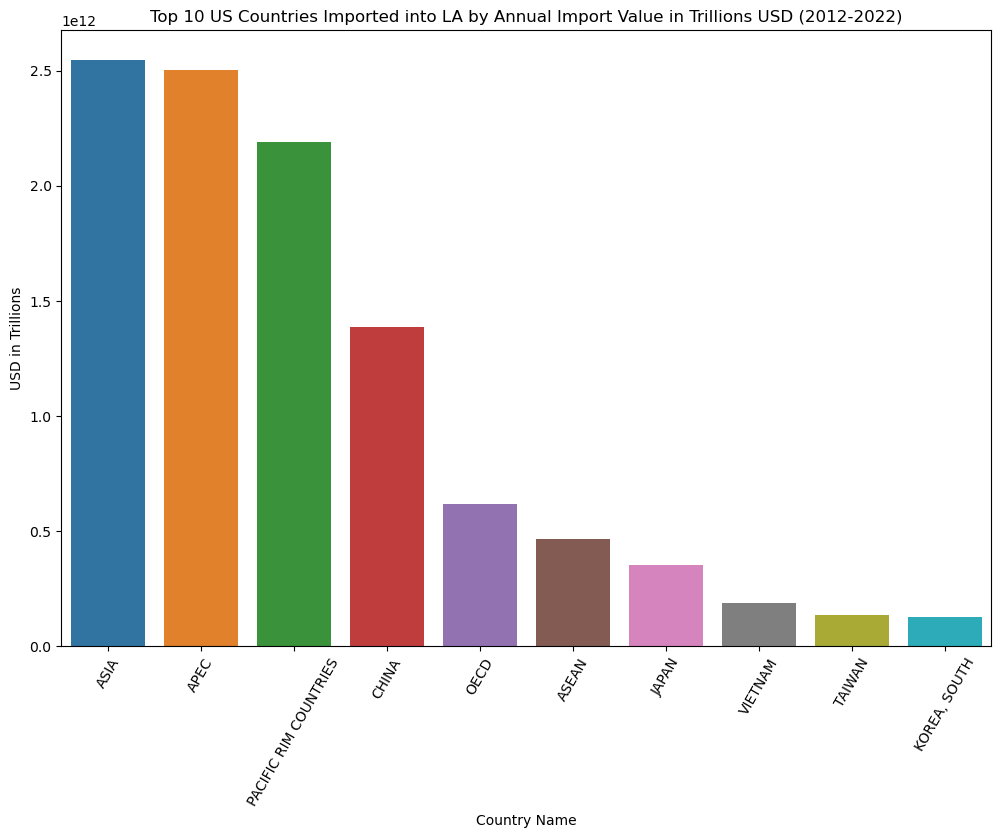

In [24]:
# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_10_countries, 
    x='CTY_NAME', 
    y='GEN_VAL_YR'
)
plt.xlabel('Country Name')
plt.ylabel('USD in Trillions')
plt.title('Top 10 US Countries Imported into LA by Annual Import Value in Trillions USD (2012-2022)')
plt.xticks(rotation=60)
plt.show()

In [25]:
# Plot the top 10 countries imported into top US Port
top_10_countries_plot = top_10_countries.hvplot(
    title='Top Countries into Top US Port (Los Angeles) by Total Import Value 2012-2022',
    yformatter="$%.0f",
    kind='bar',
    x='CTY_NAME', 
    xlabel='Country Name',
    y='GEN_VAL_YR',
    ylabel='Total Value USD',
    hover_color='yellow',
    width=1200,
    height=700,
    rot=20
)
top_10_countries_plot

:Bars   [CTY_NAME]   (GEN_VAL_YR)

![Top Countries Top Port](./plots/top_countries_top_port.png)

In [26]:
# Create a df with the top country of the top US Port flattened with distinct date rows
top_country_top_port = top_port_countries[top_port_countries['CTY_CODE'] == top_10_countries.iloc[0].CTY_CODE]
top_country_top_port

,GEN_VAL_YR,PORT_NAME,CTY_NAME,CTY_CODE,PORT,time,datetime
134,2.222420e+11,"LOS ANGELES, CA",ASIA,5XXX,2704,2012-12,2012-12-01
335,2.227424e+11,"LOS ANGELES, CA",ASIA,5XXX,2704,2013-12,2013-12-01
553,2.287644e+11,"LOS ANGELES, CA",ASIA,5XXX,2704,2014-12,2014-12-01
765,2.193104e+11,"LOS ANGELES, CA",ASIA,5XXX,2704,2015-12,2015-12-01
989,2.242795e+11,"LOS ANGELES, CA",ASIA,5XXX,2704,2016-12,2016-12-01
1207,2.331272e+11,"LOS ANGELES, CA",ASIA,5XXX,2704,2017-12,2017-12-01
1423,2.442652e+11,"LOS ANGELES, CA",ASIA,5XXX,2704,2018-12,2018-12-01
1643,2.267163e+11,"LOS ANGELES, CA",ASIA,5XXX,2704,2019-12,2019-12-01
1859,2.146738e+11,"LOS ANGELES, CA",ASIA,5XXX,2704,2020-12,2020-12-01
2070,2.496281e+11,"LOS ANGELES, CA",ASIA,5XXX,2704,2021-12,2021-12-01


In [27]:
# Calculate key metrics
mean = top_country_top_port['GEN_VAL_YR'].mean()
std_dev = top_country_top_port['GEN_VAL_YR'].std()
median = top_country_top_port['GEN_VAL_YR'].median()
max_val = top_country_top_port['GEN_VAL_YR'].max()
min_val = top_country_top_port['GEN_VAL_YR'].min()

In [28]:
top_country_top_port_plot = top_country_top_port.hvplot(
    title='Top Country Top US Port: Total Import Value by Year 2012-2022',
    yformatter="$%.0f",
    kind='bar',
    x='time', 
    xlabel='Year',
    y='GEN_VAL_YR',
    ylabel='Total Value USD',
    hover_color='yellow',
    width=1200,
    height=700,
)
top_country_top_port_plot

:Bars   [time]   (GEN_VAL_YR)

![Top Country Top Port](./plots/top_country_top_port.png)